In [45]:
import time
tot_tic = time.time()
import matplotlib.pyplot as plt
from matplotlib import colormaps
import sys
import pandas as pd
import cantera as ct
import numpy as np
import tempfile
from scipy import interpolate
from scipy.interpolate import interp1d
import ipywidgets as widgets
import os as os
from math import atan2,degrees

In [46]:
injectants =        ['CCL4'] # list of injectants, must be in the mechanism file.
injectant_concs =   [100] # injected species concentrations in furnace @ injection point (ppm)
injectant_units =   ['wt%'] # units of injected species concentration in furnace @ injection point (ppm)
ER = 0.834 
injectant_tot_conc=20 # total injected species concentration in furnace @ injection point (ppm)
injectant_port = 4 # port number of injectant
firing_rate = 45 # firing rate in kW

post_injection_res_time_step = 1e-4 # residence time grid size (seconds)
elsewhere_res_time_step = 1e-2 # residence time grid size (seconds)

In [47]:
#converting concentration to mole fraction
mechanism = 'rei_chloro.yaml' # mechanism file
gas = ct.Solution(mechanism)
orig_concs = [i for i in injectant_concs]
#convert injectant_concs from specified unit to ppm
for i in range(len(injectant_concs)):
    if injectant_units[i] == 'ppb':
        injectant_concs[i] = injectant_concs[i] * 1e3
    elif injectant_units[i] == 'ppm':
        injectant_concs[i] = injectant_concs[i]
    elif injectant_units[i] == 'pph':
        injectant_concs[i] = injectant_concs[i] * 1e-3
    elif injectant_units[i] == 'ng/g':
        injectant_concs[i] = injectant_concs[i] * 1e-3
    elif injectant_units[i] == 'mg/kg':
        injectant_concs[i] = injectant_concs[i]
    elif injectant_units[i] == 'wt%':
        injectant_concs[i] = injectant_concs[i] * 1e4
    else:
        raise ValueError("Unknown unit of concentration.")

#use ratio of injectant_concs to make the sum of the injectant_concs equal to injectant_tot_conc
injectant_concs = [i * injectant_tot_conc / sum(injectant_concs) for i in injectant_concs]

#make dictionary of injectants, concentrations, and units
compounds_info = []
for i in range(len(injectants)):
    compounds_info.append({'name': injectants[i], 'concentration': injectant_concs[i], 'unit': injectant_units[i]})

# Fetch the molar masses from Cantera for the compounds
molar_masses = {species.name: species.molecular_weight for species in gas.species()}

# Calculate moles for each compound based on the unit of concentration
total_moles = 0
for compound in compounds_info:
    compound_name = compound['name']
    if compound_name in molar_masses:
        molar_mass = molar_masses[compound_name]
        if compound['unit'] == 'ppb' or 'ng/g':
            # Convert ppb to g/g, then to moles
            compound['moles'] = (compound['concentration'] * 1e-9) / molar_mass
        elif compound['unit'] == 'ppm' or 'mg/kg':
            # Convert ppm to g/g, then to moles
            compound['moles'] = (compound['concentration'] * 1e-6) / molar_mass
        elif compound['unit'] == 'pph' or 'wt%':
            # Convert weight percent to g/g, then to moles
            compound['moles'] = (compound['concentration'] * 0.01) / molar_mass
        else:
            raise ValueError("Unknown unit of concentration.")
        total_moles += compound['moles']
    else:
        raise ValueError(f"Molar mass for {compound_name} not found in mechanism file.")

# Calculate mole fractions
for compound in compounds_info:
    compound['mole_fraction'] = compound['moles'] / total_moles

#set injection_concs to mole fractions
injectant_concs = []
for compound in compounds_info:
    injectant_concs.append(compound['mole_fraction'])

In [48]:

def strclean(s):
    return str(s).replace(' ', '').replace('[','').replace(']','').replace("'",'')

#script to generate folder name based off specified conditions, using the format specified above.
if len(injectants) > 1:
    pollutant_index = 0
    output_folder = 'Output/AFFF/'+str(pollutant_index)+str(injectant_port)+'.'+str(firing_rate).replace('.','')+'_'+str(firing_rate)+'kW_'+strclean(injectants[:3])+'_port'+str(injectant_port)
else:
    if injectants[0] == 'CF4':
        pollutant_index = 1
    elif injectants[0] == 'CHF3':
        pollutant_index = 2
    elif injectants[0] == 'CHF6':
        pollutant_index = 3
    else:
        pollutant_index = 0
        
    output_folder = 'Output/'+str(pollutant_index)+str(injectant_port)+'.'+str(firing_rate).replace('.','')+'_'+str(firing_rate)+'kW_'+strclean(injectants)+'_port'+str(injectant_port)

    
if os.path.exists(output_folder) == False: #check if output folder exists
    os.makedirs(output_folder) #create output folder if it doesn't exist
    print('Creating new folder: ' + output_folder)
else:
    #open the run_conditions.txt file and check if the same conditions are being used for this run, if so, then continue. If not, make a subfolder in the run folder with the new conditions.
    # Write the current conditions to a temporary file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        f.write('Injectants: '+ ', '.join(injectants) + '\n')
        f.write('Injectant Concentration (converted to mole fraction): '+ str(injectant_concs) + '\n')
        f.write('Injectant Total Concentration: '+ str(injectant_tot_conc) + '\n')
        f.write('Injectant Port: '+ str(injectant_port) + '\n')
        f.write('firing rate: ' + str(firing_rate) + '\n')

    # Read the contents of the temporary file and run_conditions.txt
    with open(f.name, 'r') as file1, open(output_folder+'/run_conditions.txt', 'r') as file2:
        file1_contents = [next(file1) for x in range(5)]
        file2_contents = [next(file2) for x in range(5)]
    print(file1_contents)
    print(file2_contents)
    # Check if the contents are the same
    if file1_contents == file2_contents:
        # rest of your code
        print('Same conditions, continuing with run')
    else:
        print('Different conditions, creating subfolder')
        conditions = '_'.join([strclean(injectants[i])+'-'+str(injectant_concs[i])[:5] for i in range(len(injectants))[:5]])+'_'+str(injectant_tot_conc)+'_'+str(injectant_port)+'_'+str(firing_rate)
        print(conditions)
        output_folder = output_folder+'/'+conditions
        if os.path.exists(output_folder) == False:
            os.makedirs(output_folder) #create output folder if it doesn't exist

file = open(f'{output_folder}/log.txt', 'w') #create log file
file.close() #close log file



['Injectants: CCL4\n', 'Injectant Concentration (converted to mole fraction): [1.0]\n', 'Injectant Total Concentration: 20\n', 'Injectant Port: 4\n', 'firing rate: 45\n']
['Injectants: CCL4\n', 'Injectant Concentration (converted to mole fraction): [1.0]\n', 'Injectant Total Concentration: 20\n', 'Injectant Port: 4\n', 'firing rate: 45\n']
Same conditions, continuing with run


In [49]:
import h5py
# Read the column names and the data from the HDF5 file
with h5py.File(output_folder + "\\sol.hdf5", 'r') as f:
    cantera_species = f['column_names'][:].tolist()
    sol = f['data'][:]

columns = ['Residence Time (seconds)', 'Temperature (K)'] + cantera_species
columns = [col.decode('utf-8') if isinstance(col, bytes) else col for col in columns]
# Convert newcantera_species to a list of strings
cantera_species = [species.decode('utf-8') for species in cantera_species]

tplot = sol[:, 0]
Tplot = sol[:, 1]

In [50]:
print(columns)

['Residence Time (seconds)', 'Temperature (K)', 'H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'C', 'CH', 'CH2', 'CH2(S)', 'CH3', 'CH4', 'CO', 'CO2', 'HCO', 'CH2O', 'CH2OH', 'CH3O', 'CH3OH', 'C2H', 'C2H2', 'C2H3', 'C2H4', 'C2H5', 'C2H6', 'HCCO', 'CH2CO', 'HCCOH', 'N', 'NH', 'NH2', 'NH3', 'NNH', 'NO', 'NO2', 'N2O', 'HNO', 'CN', 'HCN', 'H2CN', 'HCNN', 'HCNO', 'HOCN', 'HNCO', 'NCO', 'N2', 'AR', 'C3H7', 'C3H8', 'CH2CHO', 'CH3CHO', 'CHCL3', 'C2CL4', 'CCL4', 'HCL', 'C2CL2', 'C2HCL5', 'C2CL3', 'C2HCL3', 'CHCL2CCL2', 'C2CL6', 'CL', 'CL2', 'CH2CL', 'CH2CL2', 'CHCL2', 'CCL3', 'CCL2', 'HOCL', 'CLO', 'CLOO', 'CLOCL', 'CHCL2CHCL2', 'CHCL2CHCL', 'C2CL5', 'C2HCL', 'CHCCL2', 'CH2CLCCL2O', 'CHCLCCL', 'CHO', 'CHCLO', 'CCLO', 'CCL2OO', 'CHCL2OCL', 'CHCLOCCL2', 'CCL2CCL2O', 'CCL2O', 'CHCL2O', 'CCL3O', 'CHCL2OH', 'CHCLOH', 'CHCL2OO', 'CHCL2OOH', 'CCL2OH', 'CCL2OOH', 'CCL3OH', 'CCL3OO', 'CCL3OOH', 'CHCLCCL2OH', 'CHCLCCLOH', 'CHCLCHCL', 'CCL2CCL2OH', 'C2CL3OH', 'CCL2CCLO', 'CCL2CO', 'CHCL2CCL2O', 'CHCL2CC

In [51]:
#spent way too much time making an interactive plot, but it's pretty cool
import ipywidgets as widgets
from ipywidgets import HTML
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# List to store the species to plot
species_to_plot = ['H', 'CL', 'CCL4','HCL','CLO','CCLO','CL2']
# Calculate the minimum and maximum concentrations for each species
concentrations_glob = {species: sol[:, columns.index(species)] for species in species_to_plot}

H midpoint: 0.0002
CL midpoint: 0.0009000000000000002
CCL4 midpoint: 0.0001
HCL midpoint: 0.0001
CLO midpoint: 0.0008000000000000001
CCLO midpoint: 0.0001
CL2 midpoint: 0.0001


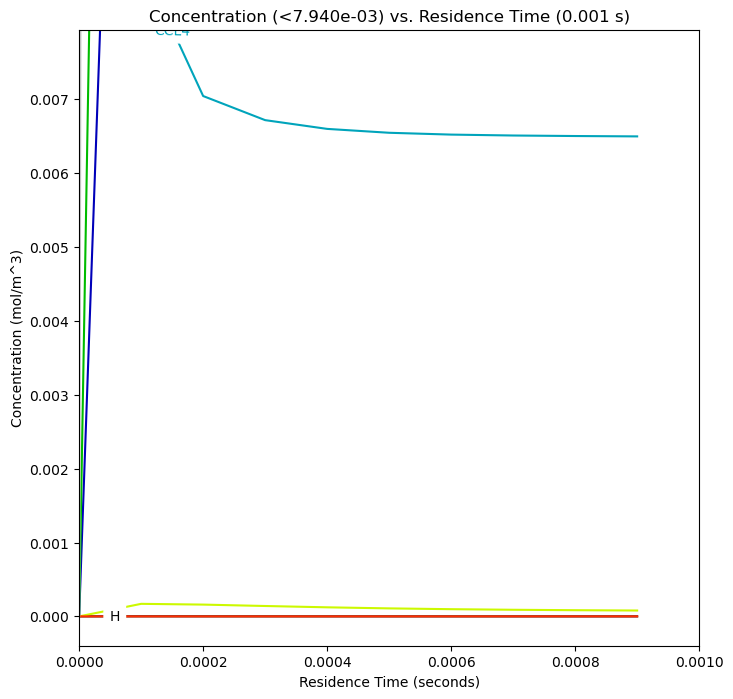

In [56]:
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()
    # print(f'x: {x}')
    # print(f'x type: {type(x)}')
    # print(f' xdata type: {type(xdata[-1])}')
    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):
    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

def update_plot(change=None):
    plt.close('all')
    global species_to_plot
    global concentrations_glob
    xlim=(0, 0.001)
    ylim=0.00794
    concentrations_glob = {species: sol[:, columns.index(species)] for species in species_to_plot}
    if not isinstance(species_to_plot, (list, tuple)):
        species_to_plot = [species_to_plot]
    

    pixel_x = 800
    pixel_y = 800
    inch_x = pixel_x / plt.rcParams["figure.dpi"]
    inch_y = pixel_y / plt.rcParams["figure.dpi"]

    _, ax = plt.subplots(figsize=(inch_x, inch_y))
    cmap = colormaps['nipy_spectral'] # Replace 'viridis' with the name of the color map you want to use
    colors = [cmap(i) for i in np.linspace(0, 1, len(species_to_plot))]
    global color_dict
    color_dict = {}
    for i, spec in enumerate(species_to_plot):
        mask = (tplot >= xlim[0]) & (tplot <= xlim[1])
        concentrations = sol[mask, columns.index(spec)]
        color_dict[spec] = colors[i]
        ax.plot(tplot[mask], concentrations, label=spec, color=colors[i])
    #make dictionary of colors for each species
    label_plot_lines(ax)
    ax.set_xlabel('Residence Time (seconds)')
    ax.set_ylabel('Concentration (mol/m^3)')
    ax.set_xlim(xlim)
    ax.set_ylim([-0.05*ylim, ylim])  # Set the lower limit of the y-axis to 0
    ax.set_title('Concentration (<{:.3e}) vs. Residence Time ({} s)'.format(ylim, xlim[1]))
    plt.show()
    # Update the maximum of the ylim slider
    

def find_visible_segment(line, xlim, ylim):
    xdata = line.get_xdata()
    ydata = line.get_ydata()
    mask = (xdata >= xlim[0]) & (xdata <= xlim[1]) & (ydata >= ylim[0]) & (ydata <= ylim[1])
    
    if xdata[mask].size == 0 or ydata[mask].size == 0:
        return None, None
    return xdata[mask], ydata[mask]

def calculate_midpoints(lines, xlim, ylim):
    midpoints = []
    for line in lines:
        xdata, ydata = find_visible_segment(line, xlim, ylim)
        
        if xdata is None or ydata is None:
            continue
        
        y_mid = (max(ydata) + min(ydata)) / 2
        idx = np.abs(ydata - y_mid).argmin()
        midpoints.append(xdata[idx])
        print(f'{line.get_label()} midpoint: {xdata[idx]}')
    return midpoints

def distribute_midpoints(midpoints, xlim):
    unique_midpoints = sorted(set(midpoints))
    # Create a dictionary to map each unique midpoint to its duplicates
    midpoint_groups = {m: [] for m in unique_midpoints}
    for i, m in enumerate(midpoints):
        midpoint_groups[m].append(i)

    # Prepare a list to hold the new distributed x-values
    distributed_xvals = [None] * len(midpoints)

    for m in unique_midpoints:
        indices = midpoint_groups[m]
        if len(indices) > 1: # If there are duplicates
            # Find neighboring unique midpoints or use plot boundaries
            left_bound = unique_midpoints[unique_midpoints.index(m) - 1] if unique_midpoints.index(m) > 0 else xlim[0]
            right_bound = unique_midpoints[unique_midpoints.index(m) + 1] if unique_midpoints.index(m) < len(unique_midpoints) - 1 else xlim[1]

            # Distribute x-values evenly between the bounds
            new_xvals = np.linspace(left_bound, right_bound, len(indices) + 2)[1:-1]

            # Assign new x-values to the original indices
            for orig_idx, new_x in zip(indices, new_xvals):
                distributed_xvals[orig_idx] = new_x
        else:
            # If no duplicates, keep the original midpoint
            distributed_xvals[indices[0]] = m

    return distributed_xvals

def find_valid_x_for_label(line, proposed_x, xlim, ylim, max_attempts=100):
    # Calculate the 5% margin for x and y limits
    x_margin = 0.05 * (xlim[1] - xlim[0])
    y_margin = 0.05 * (ylim[1] - ylim[0])
    x_min_limit = xlim[0] + x_margin
    x_max_limit = xlim[1] - x_margin
    y_min_limit = ylim[0] + y_margin
    y_max_limit = ylim[1] - y_margin

    for attempt in range(max_attempts):
        y = line.get_ydata()[np.abs(line.get_xdata() - proposed_x).argmin()]
        if x_min_limit <= proposed_x <= x_max_limit and y_min_limit <= y <= y_max_limit:
            return proposed_x
        else:
            proposed_x += (x_max_limit - x_min_limit) / max_attempts
    return None

def label_plot_lines(ax):
    '''Labels the lines in the provided Axes object, avoiding edges and overlaps'''
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    lines = ax.get_lines()
    midpoints = calculate_midpoints(lines, xlim, ylim)
    # print(f"midpoints before distribute: {midpoints}")
    xvals = distribute_midpoints(midpoints, xlim)
    # print(f'xvals after distribute: {xvals}')
    # print(f"midpoints before find_valid_x_for_label: {midpoints}")
    adjusted_xvals=[]
    for line, val in zip(lines, xvals):
        adjusted_xvals.append(find_valid_x_for_label(line, val, xlim, ylim))
    # print(f"xvals after find_valid_x_for_label: {adjusted_xvals}")
    #remove any None values from adjusted_xvals and their corresponding line from lines
    
    adjusted_xvals = [x for x in adjusted_xvals if x is not None]
    lines = [line for line, x in zip(lines, adjusted_xvals) if x is not None]
    # for label, midpoint, xval in zip(labels, midpoints, xvals):
    #     print(f"{label}:")
    #     print(f" xval - {xval}")
    #     print(f" midpoints - {midpoint}")
        # Calculate and print Adjusted Value here
    labelLines(lines, xvals=adjusted_xvals, align=True)
update_plot()


Line 1 midpoint: 4.94949494949495
Line 2 midpoint: 4.646464646464646
Line 3 midpoint: 3.6363636363636362
Line 4 midpoint: 3.131313131313131


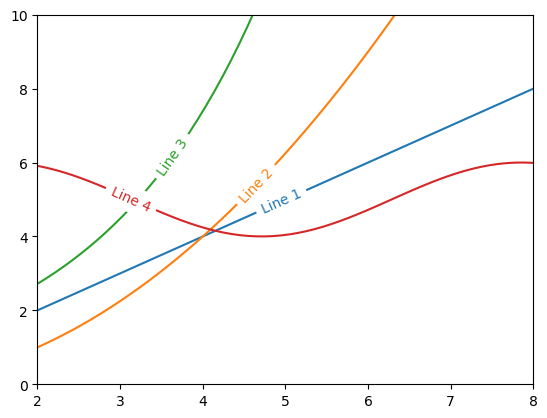

In [53]:
plt.figure()
#make a bunch of lines, using linear, polynomial, exponential, and trigonometric functions
x = np.linspace(0, 10, 100)
y1 = x
y2 = (x/2)**2
y3 = np.exp(x/2)
y4 = np.sin(x) +5


plt.plot(x ,y1, label='Line 1')
plt.plot(x, y2, label='Line 2')
plt.plot(x, y3, label='Line 3')
plt.plot(x, y4, label='Line 4')
plt.xlim(2, 8)
plt.ylim(0, 10)

ax = plt.gca()
label_plot_lines(ax)
